<a href="https://colab.research.google.com/github/emukans/en-lv-translator/blob/master/bert_translate_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Encode text embeddings with pre-trained BERT model using MS-COCO dataset

In [4]:
!pip install 'gast==0.2.2'

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3d673093740ae0465f8edc364922e9dcb92a248239a4e81c86f0f67520dc2e0e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [5]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import collections

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
from datetime import datetime

TensorFlow 1.x selected.


Using TensorFlow backend.


In [6]:
tfe = tf.contrib.eager
tfe.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Configuration

In [0]:
# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
#   multi_cased_L-12_H-768_A-12: cased multilingual
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL

LAYERS = [-1,-2,-3,-4]  # Take into account only last 4 layers
NUM_TPU_CORES = 8
MAX_SEQ_LENGTH = 128
BERT_CONFIG = BERT_PRETRAINED_DIR + '/bert_config.json'
CHKPT_DIR = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
VOCAB_FILE = BERT_PRETRAINED_DIR + '/vocab.txt'
INIT_CHECKPOINT = BERT_PRETRAINED_DIR + '/bert_model.ckpt'
BATCH_SIZE = 128
MAX_DIMENSION = 768  # 1024 for Large model


TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']

sess = tf.Session()

##Prepare MS-COCO dataset

###Load BERT embeddings if exists

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


###Download data

In [9]:
# !gcloud auth application-default login
# !gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=CxH4dtw1B_3liWc1Lnttq-Ps-crA-fiD0U2wiFxuja8&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/yQH4CL0T6iVbjU0bsEqXkKU_kMrsa5Mvzq6Jh9S1lXg-R50JT9JsdZk

You are now logged in as [eduardmukan@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [10]:
import zipfile

!gsutil -m cp gs://translator-lv-en/annotations.zip annotations.zip

with zipfile.ZipFile('annotations.zip', 'r') as zip_ref:
    zip_ref.extractall()

Copying gs://translator-lv-en/annotations.zip...
- [1/1 files][ 17.1 MiB/ 17.1 MiB] 100% Done                                    
Operation completed over 1 objects/17.1 MiB.                                     


###Preprocess data

In [0]:
raw_en_annotations = []
annotation_en_file = 'annotations/annotations.en'
with open(annotation_en_file, 'r') as f:
    raw_en_annotations = f.readlines()

def prepare_caption(caption: str):
  return f'<start> {caption.strip()} <end>'

prepared_en_caption_list = shuffle(raw_en_annotations, random_state=1)
prepared_en_caption_list = [prepare_caption(caption) for caption in prepared_en_caption_list]

raw_lv_annotations = []
annotation_lv_file = 'annotations/annotations.lv'
with open(annotation_lv_file, 'r') as f:
    raw_lv_annotations = f.readlines()

prepared_lv_caption_list = shuffle(raw_lv_annotations, random_state=1)
prepared_lv_caption_list = [prepare_caption(caption) for caption in prepared_lv_caption_list]

In [12]:
len(prepared_en_caption_list)

591823

##Prepare BERT pretrained model

In [13]:
!pip install -U sentence-transformers

     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 450kB 8.3MB/s 
     |████████████████████████████████| 1.0MB 19.3MB/s 
     |████████████████████████████████| 870kB 22.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.5.1-cp36-none-any.whl size=67076 sha256=50f3fbb2170501a0e5baea0b6a554d499841d23090f206919521980f030f25fa
  Stored in directory: /root/.cache/pip/wheels/22/ca/b4/7ca542b411730a8840f8e090df2ddacffa1c4dd9f209684c19
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=0598c9d02a5d003cf1f6c45a81ddec6d2ab3030cabb4036dfcd4af2804768a1c
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sentence-transformers sacremoses


In [14]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:19<00:00, 20.3MB/s]


In [0]:
word_embeddings1 = model.encode(prepared_en_caption_list[:100000])
np.save('gdrive/My Drive/bert_translate/word_embeddings_batch1', word_embeddings1)

In [0]:
word_embeddings2 = model.encode(prepared_en_caption_list[100000:200000])
np.save('gdrive/My Drive/bert_translate/word_embeddings_batch2', word_embeddings2)

In [0]:
word_embeddings3 = model.encode(prepared_en_caption_list[200000:300000])
np.save('gdrive/My Drive/bert_translate/word_embeddings_batch3', word_embeddings3)

In [0]:
word_embeddings4 = model.encode(prepared_en_caption_list[300000:400000])
np.save('gdrive/My Drive/bert_translate/word_embeddings_batch4', word_embeddings4)

In [0]:
word_embeddings5 = model.encode(prepared_en_caption_list[400000:500000])
np.save('gdrive/My Drive/bert_translate/word_embeddings_batch5', word_embeddings5)

In [0]:
word_embeddings6 = model.encode(prepared_en_caption_list[500000:])
np.save('gdrive/My Drive/bert_translate/word_embeddings_batch6', word_embeddings6)

##Part from image captioning

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(prepared_en_caption_list)
train_seqs = tokenizer.texts_to_sequences(prepared_en_caption_list)

In [0]:
len(tokenizer.word_counts)

1438

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(prepared_en_caption_list)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [0]:
# Create training and validation sets using an 80-20 split
word_train, word_val, cap_train, cap_val = train_test_split(word_embeddings,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [0]:
len(word_train), len(cap_train), len(word_val), len(cap_val)

(800, 800, 200, 200)

## Create a tf.data dataset for training


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(word_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 768
# attention_features_shape = 64

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((word_train, cap_train))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights
    # return x, state

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./gdrive/My Drive/bert_translate/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
def evaluate_annotation(img_tensor):
  img_tensor = tf.expand_dims(img_tensor, 0)
  features = encoder(img_tensor)
  hidden = decoder.reset_state(batch_size=1)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  for i in range(max_length):
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == '<end>':
        return result
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

In [0]:
EPOCHS = 1000

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    last_tensor = None
    last_target = None

    for (batch, (img_tensor, target)) in enumerate(dataset):
        last_tensor = img_tensor
        last_target = target
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 100 == 0:
      print('Real:')
      print(' '.join([tokenizer.index_word[predicted_id.numpy()] for predicted_id in last_target[-1]]))
      print('Predicted:')
      print(' '.join(evaluate_annotation(last_tensor[-1])))
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 2 Batch 0 Loss 2.3226
Epoch 2 Loss 2.389612
Time taken for 1 epoch 122.62391757965088 sec

Epoch 3 Batch 0 Loss 2.2076
Epoch 3 Loss 2.247705
Time taken for 1 epoch 5.440316200256348 sec

Epoch 4 Batch 0 Loss 2.1104
Epoch 4 Loss 2.138435
Time taken for 1 epoch 5.437166452407837 sec

Epoch 5 Batch 0 Loss 2.0462
Epoch 5 Loss 2.065433
Time taken for 1 epoch 5.525684118270874 sec

Epoch 6 Batch 0 Loss 1.9628
Epoch 6 Loss 2.007074
Time taken for 1 epoch 5.565618276596069 sec

Epoch 7 Batch 0 Loss 1.9207
Epoch 7 Loss 1.954520
Time taken for 1 epoch 5.47625994682312 sec

Epoch 8 Batch 0 Loss 1.8632
Epoch 8 Loss 1.897700
Time taken for 1 epoch 5.504452228546143 sec

Epoch 9 Batch 0 Loss 1.8115
Epoch 9 Loss 1.845598
Time taken for 1 epoch 5.551137924194336 sec

Epoch 10 Batch 0 Loss 1.7575
Epoch 10 Loss 1.789579
Time taken for 1 epoch 5.736809253692627 sec

Epoch 11 Batch 0 Loss 1.7078
Epoch 11 Loss 1.739188
Time taken for 1 epoch 5.587237119674683 sec

Epoch 12 Batch 0 Loss 1.6776
Epoch 1

In [0]:
np.save('gdrive/My Drive/bert_translate/loss_plot', loss_plot)

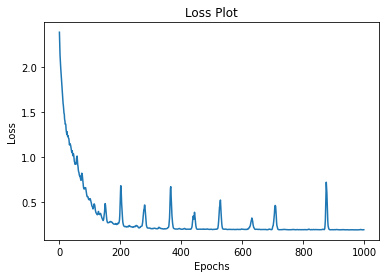

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(word):
    hidden = decoder.reset_state(batch_size=1)

    word_tensor_val = tf.expand_dims(word, 0)
    features = encoder(word_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)
    return result

In [0]:
# captions on the validation set
rid = np.random.randint(0, len(word_train))
word = word_train[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_train[rid] if i not in [0]])
result = evaluate(word)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))


Real Caption: <start> white and yellow propeller stunt plane trailing smoke while climbing steeply <end>
Prediction Caption: birds airplane flying alone of birds airplane flying alone of birds airplane flying alone of smoke at sunset at sunset standing close of smoke
